In [1]:
import pandas as pd
from nltk.probability import FreqDist
from string import punctuation
import re
import emoji
import pyvi
from collections import Counter
from pyvi import ViTokenizer, ViPosTagger
from nltk.corpus import words
from nltk.util import ngrams

In [2]:
pd.options.mode.copy_on_write = True

In [3]:
def no_accent_vietnamese(s): # Xóa dấu của từ
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

In [4]:
def check_accent(text):
    accent_character = 'àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ'
    kq = False

    for t in list(text):
        if t in accent_character:
            kq = True
    
    return kq

In [5]:
def remove_replicated(text): # Xóa chữ cái bị lặp
    # Bỏ qua từ đặc biệt
    special = ['ưu', 'ứu', 'ừu', 'ựu', 'ửu', 'ữu']
    drop_special = {}
    s_num = 0
    for s_word in special:
        if s_word in text:
            drop_special[s_word] = 'Special_%s'%s_num
            text = text.replace(s_word, 'Special_%s'%s_num)
            s_num += 1

    # Xóa dấu chữ cái
    accent_character = 'àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ'
    dict_accent_word = {}
    for c in text:
        if c in accent_character:
            p = [pos for pos, char in enumerate(text) if char == c]
            dict_accent_word[c] = p
    text = no_accent_vietnamese(text)

    # Check các chữ cái lặp
    count = Counter(text)
    check_rep_character = [k for k, v in count.items() if v > 1]
    remove_pos = {}
    for character in check_rep_character:
        positions = [pos for pos, char in enumerate(text) if char == character]
        remove_list = []
        for i in range(len(positions) - 1):
            if ((positions[i+1] - positions[i]) == 1):
                remove_list.append(positions[i])
                remove_list.append(positions[i+1])

        if remove_list != []:
            remove_pos[character] = list(set(remove_list))

    # Gán lại dấu chữ cái
    text = list(text)
    for k, v in dict_accent_word.items():
        for i in v:
            text[i] = k

    # Loại bỏ chữ cái lặp
    for c, list_pos in remove_pos.items():
        for k, v in dict_accent_word.items():
            compare = set(list_pos).intersection(v)
            if len(compare) != 0:
                for i in compare:
                    list_pos.remove(i)
                for remove_index in list_pos:
                    text[remove_index] = ''
            else:
                for remove_index in list_pos[1:]:
                    text[remove_index] = ''

    text = ''.join(text)

    # Thay lại từ đặc biệt
    for k, v in drop_special.items():
        text = text.replace(v, k)

    return text

In [6]:
def remove_abbreviations(text):
    abbreviations = pd.read_excel('abbreviations.xlsx')
    remove_abbreviations_list = []
    for t in text.split(' '):
        if t in abbreviations['abbreviation'].values:
            remove = abbreviations[abbreviations['abbreviation']==t]['word'].values[0]
            remove_abbreviations_list.append(remove)
        else:
            remove_abbreviations_list.append(t)

    text_pre = ' '.join(remove_abbreviations_list)
    return text_pre

In [28]:
def product_name_ngram():
    product_df = pd.read_csv('..\Data\Preprocessed_data\Product.csv')
    ignore_product_name = ['điện_thoại', ]

    for brand in product_df['Brand'].unique():
        ignore_product_name.append(brand.lower())

    for product in product_df['ProductName'].values:
        product = re.sub("\d+", " ", product.lower())
        product = ' '.join(product.split())
        for num in range(1, 3):
            n_grams = ngrams(product.split(' '), num)
            for n in ['_'.join(grams) for grams in n_grams]:
                ignore_product_name.append(n)
                ignore_product_name.append(n.replace('_', ' '))

    return list(set(ignore_product_name))

In [32]:
def preprocessing_text(text , ignore_list=[]):
    # Biến chữ hoa thành chữ thường
    text_pre = text.lower()

    # Loại bỏ url
    text_pre = re.sub(r'http\S+', '', text_pre)

    # Loại bỏ tên miền
    text_pre = re.sub(r"[^\s]*\.(com|vn|net)", '', text_pre)

    # Loại bỏ hashtag
    text_pre = ' '.join(re.sub("(#[A-Za-z0-9]+)", " ", text_pre).split())

    # Loại bỏ user mentions @
    text_pre = ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text_pre).split())

    # Loại bỏ dấu xuống dòng \r, \n và tab \t
    text_pre = text_pre.replace('\r', ' ').replace('\n', ' ').replace('\t', ' ')

    # Loại bỏ emoji
    text_pre = emoji.demojize(text_pre, delimiters=("", " "))
    text_pre = ' '.join([t for t in text_pre.split(' ') if '_' not in t])

    # Loại bỏ dấu câu và kí tự
    punc = punctuation
    punc += '“”…►'
    for c in punc:
        text_pre = text_pre.replace(c,' ')
    text_pre = " ".join(text_pre.split())

    # Loại bỏ chữ bị lặp
    text_pre = remove_replicated(text_pre)
    
    # Loại bỏ chữ số
    text_pre = re.sub("\d+", " ", text_pre)

    # Loại bỏ từ viết tắt và viết sai
    text_pre = remove_abbreviations(text_pre)

    # Xử lý từ phủ định

    # Loại bỏ stopword
    f = open(r"vietnamese-stopwords_edit.txt", "r", encoding="utf-8")
    List_StopWords = f.read().split("\n")
    if ignore_list != []:
        List_StopWords += ignore_list
    text_pre=" ".join(text for text in text_pre.split() if text not in List_StopWords)

    # Tokenize
    text_pre = ViTokenizer.tokenize(text_pre)

    # Pos tagging
    pos_tagger = ViPosTagger.postagging(text_pre)
    text_pre = []
    for i in range(len(pos_tagger[0])):
        if pos_tagger[1][i] in ['N'] and len(pos_tagger[0][i]) > 2 and pos_tagger[0][i] not in product_name_ngram():
            text_pre.append(pos_tagger[0][i])
    text_pre = ' '.join(text_pre)
    
    return text_pre

In [14]:
ecom_reviews = pd.read_csv(r'..\Data\Preprocessed_data\EcomReviews.csv')['Review'].dropna().reset_index(drop=True)
sm_reviews = pd.read_csv(r'..\Data\Preprocessed_data\SocialMediaReviews.csv')['Review'].dropna().reset_index(drop=True)
reviews = [item for item in list(ecom_reviews)] + [item for item in list(sm_reviews)]

In [23]:
reviews_preprocessed = [] # 15 ~ 20'
ignore_list = product_name_ngram()
for item in reviews:
    item_pre = preprocessing_text(item, ignore_list=ignore_list)
    if item_pre != '':
        reviews_preprocessed.append(item_pre)

In [24]:
list_word = []
for sentence in reviews_preprocessed:
    for word in sentence.split(' '):
        if word != '':
            list_word.append(word)

frequency_dist = FreqDist(list_word)

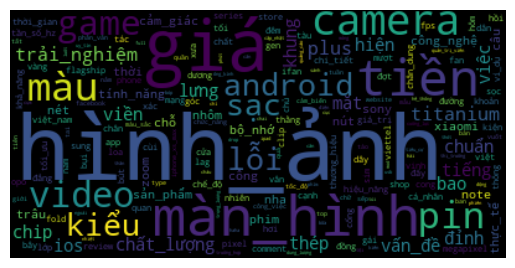

In [25]:
from wordcloud import WordCloud
wcloud = WordCloud().generate_from_frequencies(frequency_dist)

import matplotlib.pyplot as plt
plt.imshow(wcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
topic_features = {'Price': ['giá', 'tiền'],
                  'Battery': ['pin', 'thời_gian', 'điện', 'thời_lượng'],
                  'Camera': ['hình_ảnh', 'camera', 'màu', 'video', 'zoom', 'phim', 'pixel', 'megapixel', 'ống_kính', 'camera_tele'],
                  'Screen': ['màn_hình', 'tần_số_hz', 'cảm_biến', 'kích_thước', 'màn', 'cảm_ứng', 'inch'],
                  'Operating_system': ['android', 'ios', 'tính_năng', 'app', 'chức_năng', 'hệ_thống', 'đa_nhiệm', 'hệ_điều_hành', 'giao_diện'],
                  'Audio': ['tiếng', 'loa', 'ghi_âm', 'nhạc', 'mic', 'âm_lượng'],
                  'Appearance': ['kiểu', 'viền', 'khung', 'titanium', 'thép', 'nút', 'nhôm', 'cong', 'đồng', 'vàng', 'màu_sắc', 'phím', 'chất_liệu', 'vật_liệu', 'hợp_kim'],
                  'Hardware': ['game', 'chip', 'bộ_nhớ', 'hiệu_năng', 'dung_lượng', 'chip_snapdragon', 'snapdragon', 'ổ_cứng', 'fps', 'lag', 'mượt'],
                  'Accessory': ['sạc', 'sim', 'cường_lực', 'usb', 'bút_spen', 'phụ_kiện'],
                  'Network': ['mạng', 'sóng', 'wifi']
                  }

In [33]:
# data_test_model = pd.DataFrame([text for text in reviews_preprocessed if text != ''], columns=['Review'])
# data_test_model.to_csv('data_test_model.csv', index=False)